#Satisfiability Modulo Theory encoding for the VLSI problem 

Combinatorial and Decision Making Optimization Module I project

Farinola Francesco - francesco.farinola@studio.unibo.it

In [1]:
!git clone https://github.com/FrancescoFarinola/VLSI_CDMO
!pip install z3-solver
from z3 import *
%cd VLSI_CDMO/SMT/src

fatal: destination path 'VLSI_CDMO' already exists and is not an empty directory.


C:\Users\francesco.farinola\VLSI_CDMO\SMT


You should consider upgrading via the 'c:\users\francesco.farinola\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
from VLSI_CDMO.utils import input, output
#from utils import input, output
import os
import time
import re
import numpy as np

#Define constraints

## Bound coordinates (x,y)

In [3]:
def bound_coordinates(coordinate, size, max):
    '''
    Generic decomposition of the implied constraints to define the lower and upper bounds of the output coordinates 
    Calls to this function have to be made with:
        - x, width and plate_w
        - y, height and plate_h
    @args:
    - coordinate : indicates the coordinate on the axis (either x or y) (IntVector)
    - size : indicates the size of the axis (either width or height) (array of int)
    - max : indicates the upper bound for values taken by coordinate (either plate_w or plate_h) (int)
    '''
    decomposition = []
    for i in range(len(coordinate)):
        decomposition.append(And(coordinate[i] >= 0,              # Set lower bound
                                 coordinate[i] + size[i] <= max)) # Set upper bound
    return decomposition

##Diffn - no overlap

In [4]:
def diffn(x, y, width, height):
    '''
    This function defines the decomposition of the diffn global constraint in order to assure
    no overlap between circuits. Simply sum between the coordinate x and width x of a circuit 
    has to be lesser or equal than the coordinate x of another circuit.
    @args:
    - x : array of x coordinates (IntVector)
    - y : array of y coordinates (IntVector)
    - width : array of widths of the circuits (array of int)
    - height : array of heights of the circuits (array of int)
    '''
    decomposition = []
    n = len(x)
    for i in range(n):
        for j in range(i+1,n):
            decomposition.append(Or([x[i] + width[i]  <= x[j],
                                     y[i] + height[i] <= y[j],
                                     x[j] + width[j]  <= x[i],
                                     y[j] + height[j] <= y[i]]))
    return decomposition

##Cumulative [Not working]
Requires that a set of tasks given by start times, durations, and resource requirements, never require more than a global resource bound 'total' at any one time.This can be adapted to our case in which start times can be seen as coordinates x (respectively y),duration can be seen as the width of rectangles (respectively height), resources as the height (respectively width) and the total amount of resources as the maximum height (respectively the maximum width) of the plate.

@args:
- start : array of coordinates (IntVector)
- duration : size of circuits (array of int)
- resources : size of circuits (array of int)
- total : maximum size of the plate (int)


```
def cumulative(start, duration, resources, total):    
        decomposition = []
        tasks = [i for i in range(len(start)) if resources[i] > 0 and duration[i] > 0] #Assumptions of cumulative constrain r[i] and d[i]>0
        for i in tasks:
            decomposition.append(
                        Sum([If(And(start[i] <= resources[i], resources[i] < start[j] + duration[j]), resources[j], 0)
                            for j in range(len(start))]) <= total)
        return decomposition
```




##Force adjacency (similar to cumulative)

In [5]:
def force_adjacency(coordinate, size):
    '''
    This is a similar decomposition of the global constraint cumulative from MiniZinc.
    With this constraint we impose circuits to be adjacent to each other OR to the
    border. We first define an array including the possible values that a circuit's 
    coordinate can have and then produce the FOL formula.
    @args:
    - coordinate : array of x/y coordinates (IntVector)
    - size : array of widths/heights of the circuits (array of int)
    '''
    decomposition = []
    for i in range(len(coordinate)):
        lst = [0] # Border
        for j in range(len(coordinate)):
            if i != j:
                lst.append(coordinate[j]+size[j])                   # Creates list of possible adjacency values 
        decomposition.append(Or([coordinate[i] == j for j in lst])) # Encoding of Member constraint
    return decomposition

##Same dimension circuits

In [6]:
def same_dimensions(x, y, width, height):
    '''
    This constraint forces a lexicographic order between circuits with the
    same sizes. So, we check whether widths ang heights are equal between 
    two circuits and the impose an ordering between them, placing the first
    at the bottom-left w.r.t. the second one.
    @args:
    - x : array of coordinates x (IntVector)
    - y : array of coordinates y (IntVector)
    - width : array of widths of circuits (array of int)
    - height : array of heights of circuits (array of int)
    '''
    decomposition = []
    for i in range(len(width)):
        for j in range(i+1, len(width)):
            decomposition.append(Implies(And(width[i] == width[j], height[i] == height[j]), #If dimensions are equal
                                         Or(And(x[i] <  x[j], y[i] <= y[j]),                #Force x coordinate of the first circuit to be at the bottom left 
                                            And(x[i] <= x[j], y[i] <  y[j]))))              #Force y coordinate of the first circuit to be at the bottom left 
    return decomposition

##Biggest circuit

In [7]:
def place_biggest_circuit(x, y, area):
    '''
    Impose lexicographic order between the first biggest circuit and the 
    second one being the first biggest circuit be always at the bottom left
    part w.r.t. the second biggest one.
    @args
    - x : coordinates x of the circuits (IntVector)
    - y : coordinates x of the circuits (IntVector)
    - area : array of indexes of the circuits sorted by decreasing area - precomputed (np.array)
    '''
    return [Or(And(x[area[0]] <  x[area[1]], y[area[0]] <= y[area[1]]),        #Force x coordinate of the first biggest circuit to be at the bottom left 
                   And(x[area[0]] <= x[area[1]], y[area[0]] <  y[area[0]]))]   #Force y coordinate of the first biggest circuit to be at the bottom left 


## Rotation constraints



1.   Do not rotate squares
2.   Do not rotate both circuits if their inverted sizes are equal



In [8]:
def do_not_rotate_squares(width, height, rotation):
    '''
    This constraint imposes that a circuit cannot be rotated if its width and height are equal
    @args:
    - width : array of widths of the circuits (array of ints)
    - height : array of heights of the circuits (array of ints)
    - rotation : array of booleans indicating whether a circuits has to be rotated or not (BoolVector)
    '''
    decomposition = []
    for i in range (len(width)):
        decomposition.append(Implies(width[i]==height[i], rotation[i]==False))                # If width is equal to height set rotation=False
    return decomposition

def do_not_rotate_both_circuits(width, height, rotation):
    '''
    With this constraint we force two circuits to not be both rotated if their inverted sizes
    are the same of before. If we have two circuits each of size 2x3 and 3x2 they both cannot
    be rotated as they are interchangeable.
    @args:
    - width : array of widths of the circuits (array of ints)
    - height : array of heights of the circuits (array of ints)
    - rotation : array of booleans indicating whether a circuits has to be rotated or not (BoolVector)
    '''
    decomposition = []
    for i in range (len(width)):
        for j in range (len(width)):
            if j!=i:
                decomposition.append(Implies(And(width[i]==height[j], height[i]==width[j]),   # If inverted sizes are equal
                                             Or(And(rotation[i]==False, rotation[j]==False),  # Both circuits cannot be rotated
                                                And(rotation[i]==True, rotation[j]==False),   # Or rotate only first circuit
                                                And(rotation[i]==False, rotation[j]==True)))) # Or rotate only second circuit
    return decomposition

## Function to output results



In [9]:
def write_output(path, i, plate_w, plate_h, circuits):
    out_file = path + "/ins-" + str(i) + ".txt"
    with open(out_file, 'w') as f:
        f.write("{0} {1}\n".format(plate_w, plate_h))
        f.write("{0}\n".format(len(circuits)))
        for i in range(0,len(circuits)):
            f.write("{0} {1} {2} {3}\n".format(circuits[i][0], circuits[i][1], circuits[i][2], circuits[i][3]))
        f.close()
    return out_file

# Model without rotation

['../instances/ins-1.txt', '../instances/ins-2.txt', '../instances/ins-3.txt', '../instances/ins-4.txt', '../instances/ins-5.txt', '../instances/ins-6.txt', '../instances/ins-7.txt', '../instances/ins-8.txt', '../instances/ins-9.txt', '../instances/ins-10.txt', '../instances/ins-11.txt', '../instances/ins-12.txt', '../instances/ins-13.txt', '../instances/ins-14.txt', '../instances/ins-15.txt', '../instances/ins-16.txt', '../instances/ins-17.txt', '../instances/ins-18.txt', '../instances/ins-19.txt', '../instances/ins-20.txt', '../instances/ins-21.txt', '../instances/ins-22.txt', '../instances/ins-23.txt', '../instances/ins-24.txt', '../instances/ins-25.txt', '../instances/ins-26.txt', '../instances/ins-27.txt', '../instances/ins-28.txt', '../instances/ins-29.txt', '../instances/ins-30.txt', '../instances/ins-31.txt', '../instances/ins-32.txt', '../instances/ins-33.txt', '../instances/ins-34.txt', '../instances/ins-35.txt', '../instances/ins-36.txt', '../instances/ins-37.txt', '../insta

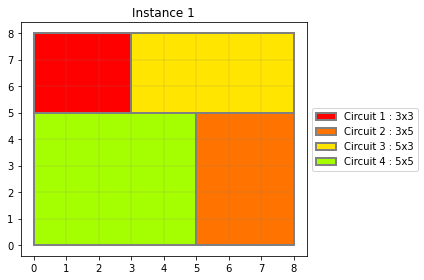

Elapsed time: 0.0109s

Solving instance 2


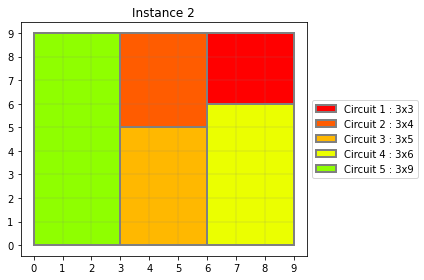

Elapsed time: 0.0209s

Solving instance 3


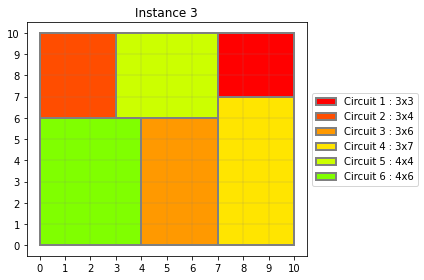

Elapsed time: 0.0449s

Solving instance 4


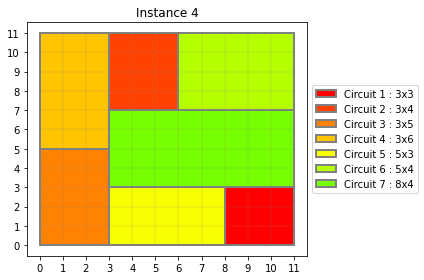

Elapsed time: 0.0379s

Solving instance 5


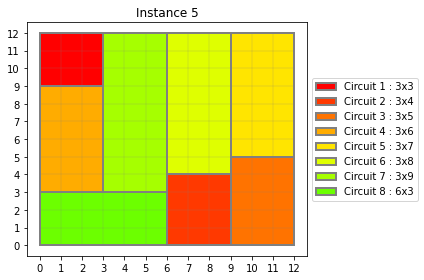

Elapsed time: 0.1188s

Solving instance 6


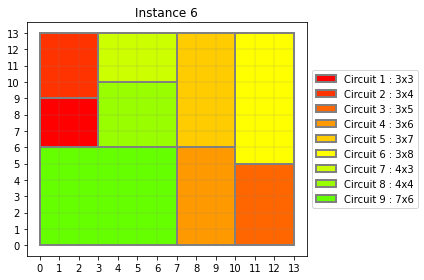

Elapsed time: 0.2455s

Solving instance 7


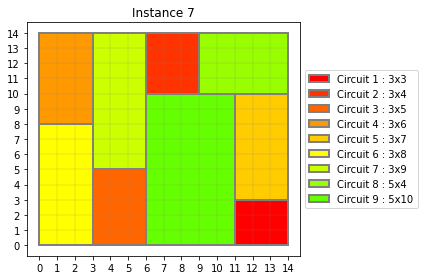

Elapsed time: 0.2284s

Solving instance 8


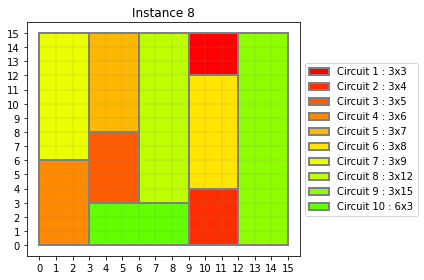

Elapsed time: 0.3239s

Solving instance 9


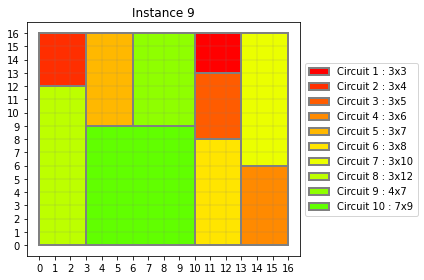

Elapsed time: 0.5018s

Solving instance 10


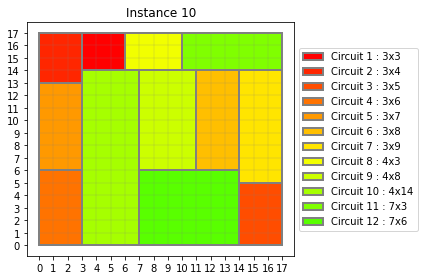

Elapsed time: 0.9377s

Solving instance 11
Non optimal solution found, but timed out
Solving instance 12


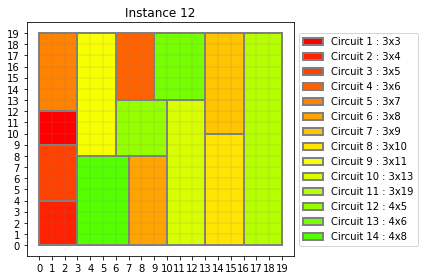

Elapsed time: 2.5386s

Solving instance 13


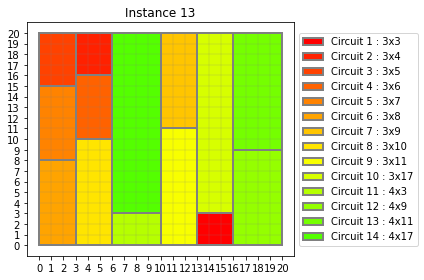

Elapsed time: 3.092s

Solving instance 14


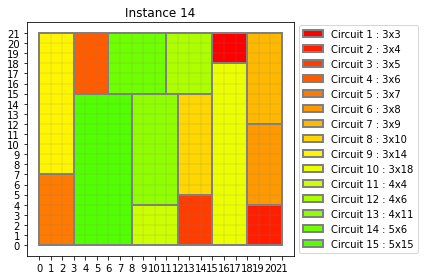

Elapsed time: 10.2116s

Solving instance 15


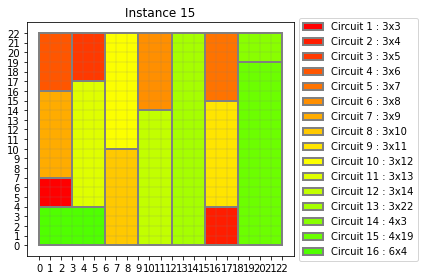

Elapsed time: 5.1218s

Solving instance 16
Non optimal solution found, but timed out
Solving instance 17


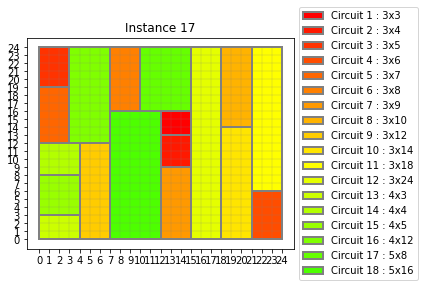

Elapsed time: 15.3519s

Solving instance 18


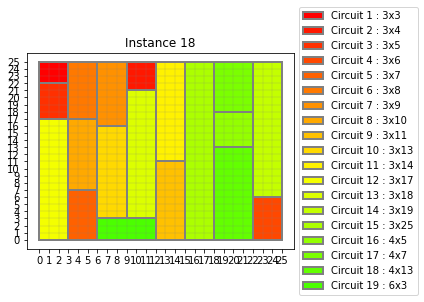

Elapsed time: 22.2783s

Solving instance 19
Non optimal solution found, but timed out
Solving instance 20
Non optimal solution found, but timed out
Solving instance 21
Non optimal solution found, but timed out
Solving instance 22
Non optimal solution found, but timed out
Solving instance 23


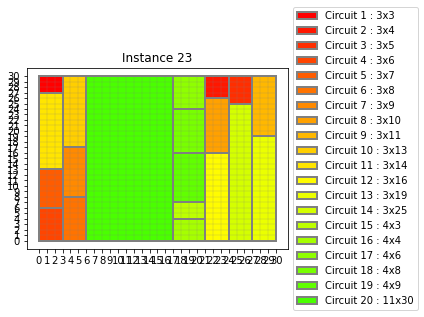

Elapsed time: 54.3049s

Solving instance 24


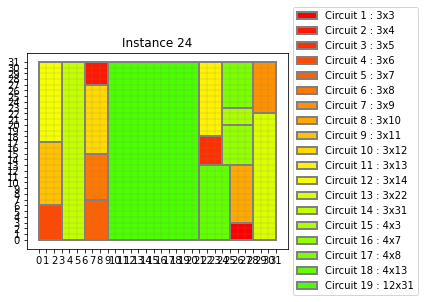

Elapsed time: 55.7438s

Solving instance 25
Non optimal solution found, but timed out
Solving instance 26
Non optimal solution found, but timed out
Solving instance 27


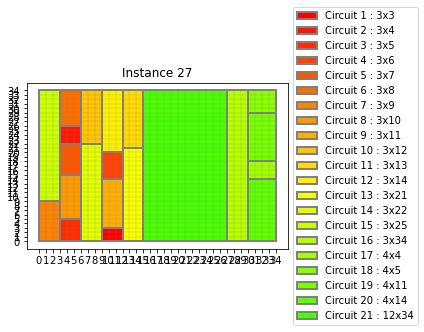

Elapsed time: 213.9097s

Solving instance 28


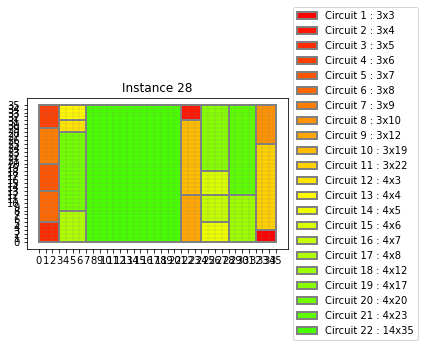

Elapsed time: 202.4544s

Solving instance 29
Non optimal solution found, but timed out
Solving instance 30
Non optimal solution found, but timed out
Solving instance 31


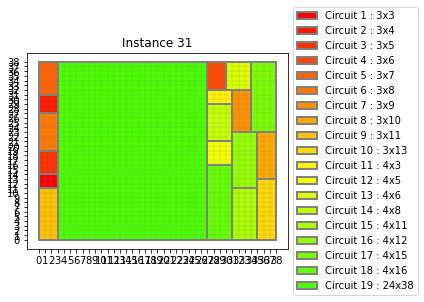

Elapsed time: 55.3273s

Solving instance 32
Non optimal solution found, but timed out
Solving instance 33


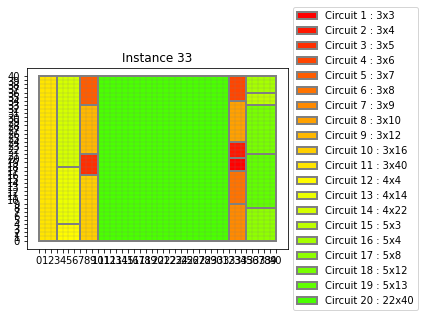

Elapsed time: 115.2796s

Solving instance 34
Non optimal solution found, but timed out
Solving instance 35
Non optimal solution found, but timed out
Solving instance 36
Non optimal solution found, but timed out
Solving instance 37
Non optimal solution found, but timed out
Solving instance 38
Non optimal solution found, but timed out
Solving instance 39
Non optimal solution found, but timed out
Solving instance 40
Non optimal solution found, but timed out
Solved instances : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '17', '18', '23', '24', '27', '28', '31', '33']
Timed out instances : ['11', '16', '19', '20', '21', '22', '25', '26', '29', '30', '32', '34', '35', '36', '37', '38', '39', '40']
Total solved : 22/40
Not solved : []
Elapsed times : {'1': 0.0109, '2': 0.0209, '3': 0.0449, '4': 0.0379, '5': 0.1188, '6': 0.2455, '7': 0.2284, '8': 0.3239, '9': 0.5018, '10': 0.9377, '12': 2.5386, '13': 3.092, '14': 10.2116, '15': 5.1218, '17': 15.3519, '18': 22.27

In [ ]:
path = "../../instances/"
input_files = sorted(sorted([path + i for i in os.listdir(path)], key=len)[:9]) + sorted(sorted([path + i for i in os.listdir(path)], key=len)[9:])
print(input_files)
times = {}
timed_out = []
no_sol = []


for i in input_files:                                   # Iterate over all instances
  plate_w, n, width, height = input.read_instance(i)    # Read instances from txt file
  instance_n = re.findall(r'\d+', i)[0]
  print("Solving instance {0}".format(instance_n))
  s = Optimize()                                        # Initialize Optimize object

  # === Output variables ===
  plate_h = Int('plate_h')
  x = IntVector('x', n)
  y = IntVector('y', n)

  area = sorted(np.argsort([height[i] * width[i] for i in range(n)]), reverse=True)# Indexes of circuits sorted by decreasing area

  # === Add constraints ===
  s.add(bound_coordinates(x, width, plate_w) +
        bound_coordinates(y, height, plate_h) +
        diffn(x, y, width, height) + 
        force_adjacency(x, width) +
        force_adjacency(y, height) +
        same_dimensions(x, y, width, height) +
        place_biggest_circuit(x, y, area)
  )
  s.set(timeout=300*1000)                               # Set timeout in milliseconds for solving
  s.minimize(plate_h)                                   # Set variable to minimize (plate height)

  # === Set output directory ===
  out_path = "../out"
  if not os.path.isdir(out_path):                     
      os.mkdir(out_path)

  start_time = time.time()                              # Init start time
  if s.check() == sat:                                  # If model is SAT
      m = s.model()
      circuits = [(wi, hi, m.eval(xi).as_long(), m.eval(yi).as_long()) for wi, hi, xi, yi in zip(width, height, x, y)] # Evaluate x and y coordinates
      h = m.eval(plate_h).as_long()                     # Get solution
      elapsed_time = round(time.time() - start_time, 4) # Calculate elapsed time
      out = write_output(out_path, instance_n, plate_w, h, circuits) # Write output on a txt file in the output directory

      # === Plot solution ===
      chip, circuits = output.load_solution(out)        
      title = "Instance {0}".format(instance_n)
      output.plot_grid(chip, circuits, title, i)
      print("Elapsed time: " + str(elapsed_time) + "s\n")
      times[instance_n] = elapsed_time

  elif s.check() == unknown:                            # unknown means model is sat but an optimal solution was not found 
      print("Non optimal solution found, but timed out")
      timed_out.append(instance_n)
  else:                                                 # Model is UNSAT
      print(s.check())      
      no_sol.append(instance_n)

print("Solved instances : {0}\n"    .format(list(times.keys())) +
      "Timed out instances : {0}\n" .format(timed_out) +
      "Total solved : {0}/{1}\n"    .format(len(times), len(input_files)) +
      "Not solved : {0}\n"          .format(no_sol) +
      "Elapsed times : {0}\n"       .format(times) +
      "Mean time : {0}"             .format(round(sum(times.values())/len(times),4)))

#Model with rotation allowed

Solving instance 1
8 [(3, 3, 0, 5), (3, 5, 5, 0), (5, 3, 3, 5), (5, 5, 0, 0)]
[False, False, False, False]


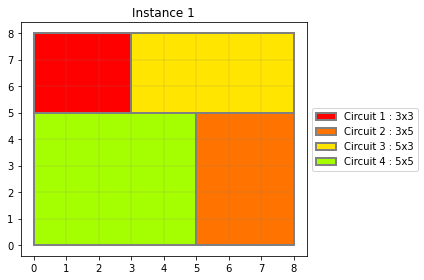

Elapsed time: 0.015s

Solving instance 2
9 [(3, 3, 6, 6), (3, 4, 0, 5), (3, 5, 0, 0), (3, 6, 6, 0), (3, 9, 3, 0)]
[False, False, False, False, False]


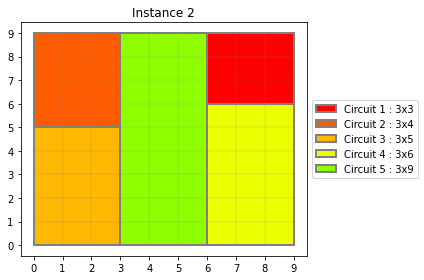

Elapsed time: 0.0489s

Solving instance 3
10 [(3, 3, 0, 7), (3, 4, 3, 6), (3, 6, 7, 0), (3, 7, 0, 0), (4, 4, 6, 6), (4, 6, 3, 0)]
[False, False, False, False, False, False]


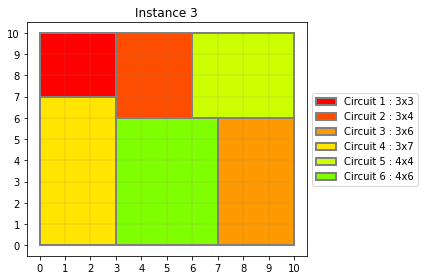

Elapsed time: 0.0937s

Solving instance 4
11 [(3, 3, 0, 3), (3, 4, 3, 7), (3, 5, 0, 6), (6, 3, 5, 0), (5, 3, 0, 0), (5, 4, 6, 7), (8, 4, 3, 3)]
[False, False, False, True, False, False, False]


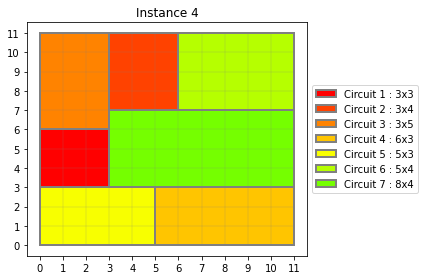

Elapsed time: 0.3511s

Solving instance 5
12 [(3, 3, 0, 3), (3, 4, 6, 8), (3, 5, 9, 7), (3, 6, 0, 6), (3, 7, 9, 0), (3, 8, 6, 0), (3, 9, 3, 3), (6, 3, 0, 0)]
[False, False, False, False, False, False, False, False]


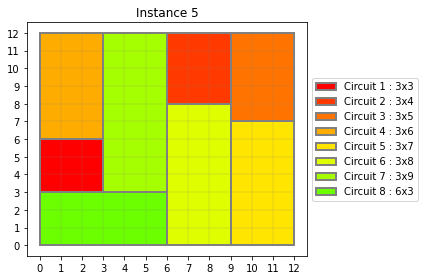

Elapsed time: 1.0522s

Solving instance 6
13 [(3, 3, 10, 3), (3, 4, 0, 6), (5, 3, 8, 10), (6, 3, 7, 0), (3, 7, 7, 3), (8, 3, 0, 10), (3, 4, 10, 6), (4, 4, 3, 6), (7, 6, 0, 0)]
[False, False, True, True, False, True, True, False, False]


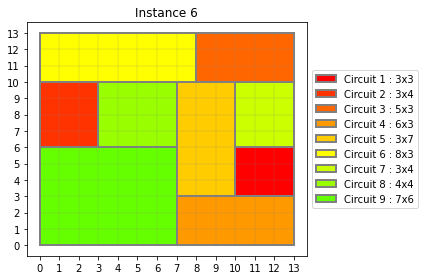

Elapsed time: 3.1612s

Solving instance 7
14 [(3, 3, 0, 0), (4, 3, 7, 6), (5, 3, 6, 3), (6, 3, 0, 3), (7, 3, 0, 6), (8, 3, 3, 0), (3, 9, 11, 0), (4, 5, 10, 9), (10, 5, 0, 9)]
[False, True, True, True, True, True, False, True, True]


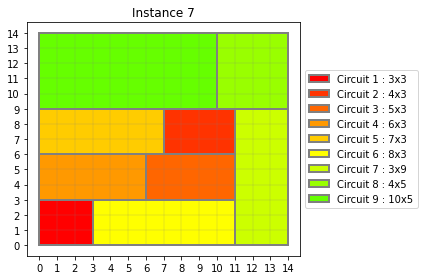

Elapsed time: 3.902s

Solving instance 8
15 [(3, 3, 9, 3), (3, 4, 0, 0), (3, 5, 0, 10), (3, 6, 0, 4), (3, 7, 3, 8), (3, 8, 3, 0), (3, 9, 9, 6), (3, 12, 6, 3), (3, 15, 12, 0), (6, 3, 6, 0)]
[False, False, False, False, False, False, False, False, False, False]


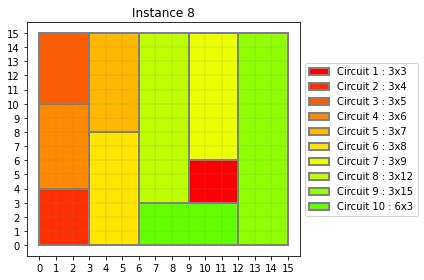

Elapsed time: 0.4827s

Solving instance 9
16 [(3, 3, 3, 7), (3, 4, 0, 12), (5, 3, 11, 13), (6, 3, 3, 10), (7, 3, 9, 10), (8, 3, 3, 13), (10, 3, 6, 7), (3, 12, 0, 0), (4, 7, 12, 0), (9, 7, 3, 0)]
[False, False, True, True, True, True, True, False, False, True]


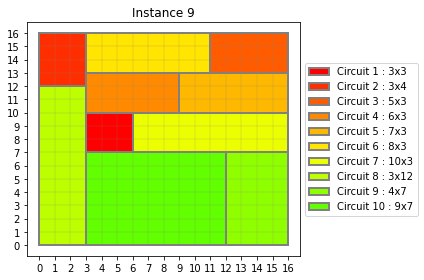

Elapsed time: 4.5389s

Solving instance 10
17 [(3, 3, 0, 11), (3, 4, 0, 0), (5, 3, 9, 14), (3, 6, 14, 0), (3, 7, 0, 4), (3, 8, 7, 0), (9, 3, 0, 14), (3, 4, 14, 6), (4, 8, 3, 0), (4, 14, 10, 0), (3, 7, 14, 10), (7, 6, 3, 8)]
[False, False, True, False, False, False, True, True, False, False, True, False]


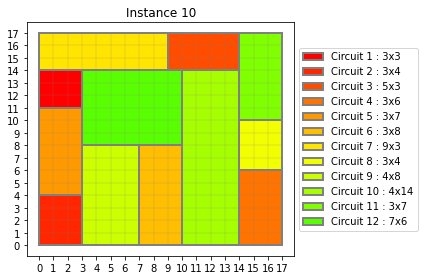

Elapsed time: 182.0367s

Solving instance 11
Non optimal solution found, but timed out
Solving instance 12
Non optimal solution found, but timed out
Solving instance 13
Non optimal solution found, but timed out
Solving instance 14
Non optimal solution found, but timed out
Solving instance 15
Non optimal solution found, but timed out
Solving instance 16
Non optimal solution found, but timed out
Solving instance 17
Non optimal solution found, but timed out
Solving instance 18
Non optimal solution found, but timed out
Solving instance 19
Non optimal solution found, but timed out
Solving instance 20
Non optimal solution found, but timed out
Solving instance 21
Non optimal solution found, but timed out
Solving instance 22
Non optimal solution found, but timed out
Solving instance 23
Non optimal solution found, but timed out
Solving instance 24
Non optimal solution found, but timed out
Solving instance 25
Non optimal solution found, but timed out
Solving instance 26
Non optimal solution foun

In [11]:
times_r = {}
timed_out_r = []
no_sol_r = []
path = "../../instances/"
input_files = sorted(sorted([path + i for i in os.listdir(path)], key=len)[:9]) + sorted(sorted([path + i for i in os.listdir(path)], key=len)[9:])
for i in input_files:                                   # Iterate over all instances 
  
  plate_w, n, width, height = input.read_instance(i)    # Get inputs from txt file
  instance_n = re.findall(r'\d+', i)[0]
  print("Solving instance {0}".format(instance_n))
  s = Optimize()                                        # Init Optimize object

  # === Output Variables ===
  plate_h = Int('plate_h')          # Variable to minimize
  x = IntVector('x', n)             # Vector of x coordinates    
  y = IntVector('y', n)             # Vector of y coordinates
  rotation = BoolVector('r', n)     # Vector of bools indicating whether to rotate or not the i-th circuit

  # === Vectors for actual width and actual height of the circuits ===
  # Invert dimensions if rotation[i] = True
  w = [If(And(x[i] != y[i], rotation[i]), height[i], width[i]) for i in range(n)] 
  h = [If(And(x[i] != y[i], rotation[i]), width[i], height[i]) for i in range(n)]

  area = sorted(np.argsort([height[i] * width[i] for i in range(n)]), reverse=True) #indexes of circuits sorted by decreasing area

  # === Add constraints ===
  s.add(bound_coordinates(x, w, plate_w) +
        bound_coordinates(y, h, plate_h) +
        diffn(x, y, w, h) + 
        force_adjacency(x, w) +
        force_adjacency(y, h) +
        same_dimensions(x, y, w, h) +
        place_biggest_circuit(x, y, area) +
        do_not_rotate_squares(width, height, rotation) +
        do_not_rotate_both_circuits(width, height, rotation)
  )
  s.set(timeout=300*1000)                               # Set timeout in milliseconds for solving
  s.minimize(plate_h)                                   # Set variable to minimize (plate height)

  # === Set out path ===
  out_path = "../out-rot"
  if not os.path.isdir(out_path):
      os.mkdir(out_path)

  start_time = time.time()                              # Init start time
  if s.check() == sat:                                  # If model is SAT
      m = s.model()
      circuits = [(m.eval(wi), m.eval(hi), m.eval(xi).as_long(), m.eval(yi).as_long()) for wi, hi, xi, yi in zip(w, h, x, y)] # Get solution for coordinates and dims
      r = [is_true(m.eval(rotation[i])) for i in range(n)] # Get solution for rotation vector
      h = m.eval(plate_h).as_long()                     # Get solution for plate height
      elapsed_time = round(time.time() - start_time, 4) #Calculate elapsed time in seconds
      print(h, circuits)
      print(r)
      out = write_output(out_path, instance_n, plate_w, h, circuits) # Write output to txt file

      # === Plot solution ===
      chip, circuits = output.load_solution(out)
      title = "Instance {0}".format(instance_n)
      output.plot_grid(chip, circuits, title, i)
      print("Elapsed time: " + str(elapsed_time) + "s\n")
      times_r[instance_n] = elapsed_time

  elif s.check() == unknown:                            # unknown means model is sat but an optimal solution was not found 
      print("Non optimal solution found, but timed out")
      timed_out_r.append(instance_n)
  else:                                                 # Model is UNSAT
      print(s.check())
      no_sol_r.append(instance_n)

print("Solved instances : {0}\n"    .format(list(times_r.keys())) +
      "Timed out instances : {0}\n" .format(timed_out_r) +
      "Total solved : {0}/{1}\n"    .format(len(times_r), len(input_files)) +
      "Elapsed times : {0}\n"       .format(times_r) +
      "Mean time : {0}"             .format(round(sum(times_r.values())/len(times_r),4)))

#Results and Plot

In [26]:
solved = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '12', '13', '14', '15', '17', '18', '23', '24', '27', '28', '31', '33']
timed_out = ['11', '16', '19', '20', '21', '22', '25', '26', '29', '30', '32', '34', '35', '36', '37', '38', '39', '40']
#Total solved  22/40
not_solved = []
elapsed_times = {'1': 0.0109, '2': 0.0209, '3': 0.0449, '4': 0.0379, '5': 0.1188, '6': 0.2455, '7': 0.2284, '8': 0.3239, '9': 0.5018, '10': 0.9377, '12': 2.5386, '13': 3.092, '14': 10.2116, '15': 5.1218, '17': 15.3519, '18': 22.2783, '23': 54.3049, '24': 55.7438, '27': 213.9097, '28': 202.4544, '31': 55.3273, '33': 115.2796}
mean_time = 34.4584

In [30]:
solved_r =  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
timed_out_r = ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']
#Total solved = 10/40
elapsed_times_r = {'1': 0.015, '2': 0.0489, '3': 0.0937, '4': 0.3511, '5': 1.0522, '6': 3.1612, '7': 3.902, '8': 0.4827, '9': 4.5389, '10': 182.0367}
mean_time_r = 19.5682

In [34]:
t1 = []
t2 = []
for i in range (1,41):
    if str(i) in elapsed_times.keys():
        t1.append(elapsed_times.get(str(i)))
    else:
        t1.append(0)
    if str(i) in elapsed_times_r.keys():
        t2.append(elapsed_times_r.get(str(i)))
    else:
        t2.append(0)

[0.0109, 0.0209, 0.0449, 0.0379, 0.1188, 0.2455, 0.2284, 0.3239, 0.5018, 0.9377, 0, 2.5386, 3.092, 10.2116, 5.1218, 0, 15.3519, 22.2783, 0, 0, 0, 0, 54.3049, 55.7438, 0, 0, 213.9097, 202.4544, 0, 0, 55.3273, 0, 115.2796, 0, 0, 0, 0, 0, 0, 0] [0.015, 0.0489, 0.0937, 0.3511, 1.0522, 3.1612, 3.902, 0.4827, 4.5389, 182.0367, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


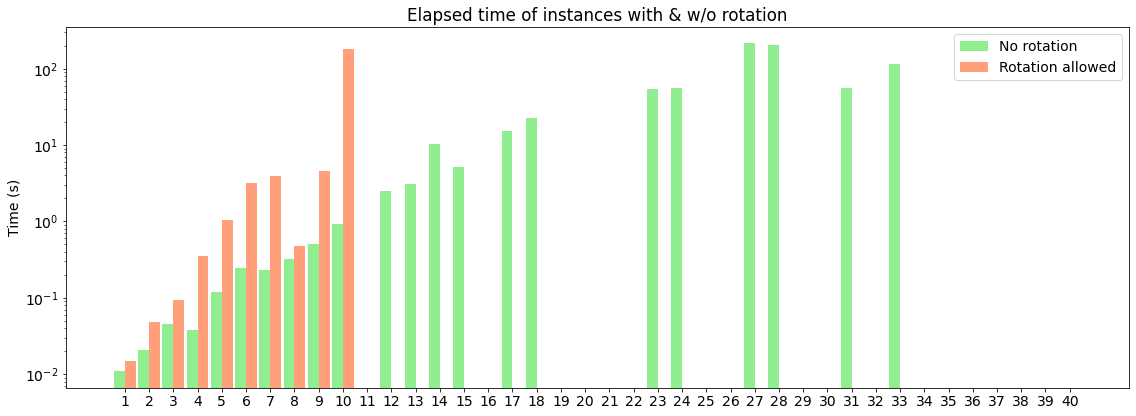

In [64]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,6)
plt.rcParams["font.size"] = 14

#labels = [str(i) for i in range(1,41)]

labels = np.arange(1, 41)  # the label locations
range = np.arange(len(labels))
width = 0.45  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(range - width/2, t1, width, color = 'lightgreen', label='No rotation')
rects2 = ax.bar(range + width/2, t2, width, color = 'lightsalmon', label='Rotation allowed')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_yscale('log')
ax.set_title('Elapsed time of instances with & w/o rotation')
ax.set_xticks(range, labels)
ax.legend()


fig.tight_layout()

plt.show()